In [23]:
import numpy as np
import numpy.random as npr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale as scaler
import torch.nn as nn
import torch
import torch.nn.functional as F
import robust_loss_pytorch.general
from tqdm.notebook import tqdm
plt.style.use('ggplot')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
np.random.seed(1)
torch.manual_seed(1)

In [24]:
# synthetic data 1
X = np.arange(-5, 5, 0.01)
noise = npr.normal(1/2*X**2 + X, np.abs(X)+0.1, len(X))
base = 1/2*X**2 + 3*np.sin(2*X)-X
Y = base + noise
Y_ = base
noise = noise

Text(0, 0.5, 'epsilon')

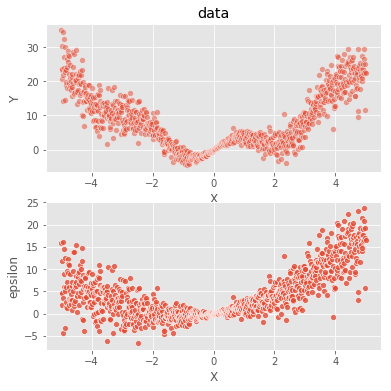

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(6,6))
sns.scatterplot(X, Y, alpha=0.5, ax=ax[0])
ax[0].set_title('data')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
sns.scatterplot(X, noise, ax=ax[1], alpha=0.8)
ax[1].set_xlabel('X')
ax[1].set_ylabel('epsilon')

In [26]:
# insert outliers
def generate_data(n, rate=0.01, loc=[2,5], y=15):
    """
    n : number of data to generate
    rate : rate of outliers (set 0 if you don't want outlier)
    loc : mean location on x-axis for outliers 
    y : mean for outliers
    
    return 
    X : x-coordinate
    output : y-coordinate from noise less model
    Y : noisy output 
    """
    # base data
    X = npr.uniform(-5, 5, n)
    noise = npr.normal(1/2*X**2 + X, np.abs(X)+0.1, len(X))
    output = 1/2*X**2 + 3*np.sin(2*X)-X
    Y = output+noise
    
    # generate outliers
    if not isinstance(loc, list):
        loc = [loc]
    out = int(n*rate/len(loc))
    Xout = []
    Yout = []
    for l in loc:
        out_data = npr.multivariate_normal([0,0], [[0.03,0],[0,0.5]], out)
        out_x = out_data[:, 0]+l
        out_y = out_data[:, 1]+y
        Xout.append(out_x)
        Yout.append(out_y)
    Xout = np.hstack(Xout)
    Yout = np.hstack(Yout)
    X = np.hstack([X, Xout])
    Y = np.hstack([Y, Yout])
    output = 1/2*X**2 + 3*np.sin(2*X)-X
    return X, output, Y

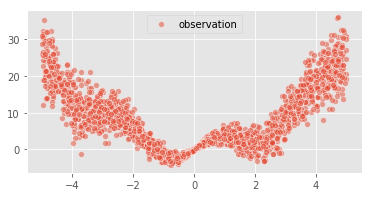

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
X, Y, Yobs = generate_data(2000, rate=0.00, loc=[-2], y=-5)
sns.scatterplot(X, Yobs, alpha=0.5, label='observation')

# Train parametric model in ERM 

In [28]:
class Regression1D(torch.nn.Module): 
    # A simple linhttp://localhost:8888/notebooks/notebook/experiment1_parametric_parametric.ipynb#ear regression module.
    def __init__(self): 
        super(Regression1D, self).__init__() 
        self.linear = torch.nn.Linear(1, 1)
    def forward(self, x): 
        return torch.exp(self.linear(x[:,None])[:,0])
    
class Regression2D(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Regression2D, self).__init__() 
        self.linear = torch.nn.Linear(2, 1)
    def forward(self, x): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        return torch.exp(self.linear(x)[:,0])

In [29]:
# normalize
Yobs = scaler(Yobs)
X = scaler(X)


alpha1 = Regression1D()
alpha2 = Regression2D()

scale1 = Regression1D()
scale2 = Regression2D()

## Linear model

In [30]:
# try optimizing alternatively?
opt1 = torch.optim.Adam(list(alpha1.parameters())+list(scale1.parameters()), lr = 0.01) 
x = torch.Tensor(X)
y = torch.Tensor(Yobs)

In [31]:
# train 
for epoch in tqdm(range(10000)):     
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y - x, alpha=alpha1(x), scale=scale1(x)))

    opt1.zero_grad() 
    loss.backward() 
    opt1.step() 

    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

0   : loss=1.001826
1000: loss=0.007139
2000: loss=0.002101
3000: loss=0.000927
4000: loss=0.000476
5000: loss=0.000263
6000: loss=0.000151
7000: loss=0.000089
8000: loss=0.000053
9000: loss=0.000032



Text(0.5, 0, 'X')

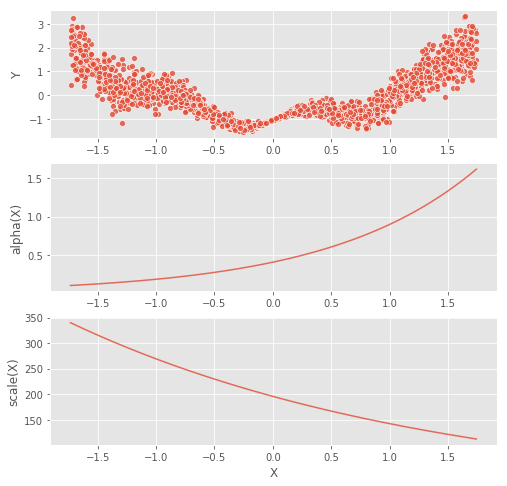

In [32]:
# plot result
alpha_y_reg = alpha1(x).data.numpy()
scale_y_reg = scale1(x).data.numpy()
fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.scatterplot(X, Yobs, alpha=0.8, ax=ax[0])
sns.lineplot(X, alpha_y_reg, alpha=0.8, ax=ax[1])
sns.lineplot(X, scale_y_reg, alpha=0.8, ax=ax[2])

ax[0].set_ylabel('Y')
ax[1].set_ylabel('alpha(X)')
ax[2].set_ylabel('scale(X)')
ax[2].set_xlabel('X')

In [33]:
## Polynomial model

In [34]:
# try optimizing alternatively?
opt1 = torch.optim.Adam(list(alpha2.parameters())+list(scale2.parameters()), lr = 0.01) 
x = torch.Tensor(X)
y = torch.Tensor(Yobs)

In [35]:
# train 
for epoch in tqdm(range(10000)):     
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y - x, alpha=alpha2(x), scale=scale2(x)))

    opt1.zero_grad() 
    loss.backward() 
    opt1.step() 

    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

0   : loss=0.361786
1000: loss=0.002577
2000: loss=0.000791
3000: loss=0.000355
4000: loss=0.000184
5000: loss=0.000103
6000: loss=0.000059
7000: loss=0.000035
8000: loss=0.000021
9000: loss=0.000012



Text(0.5, 0, 'X')

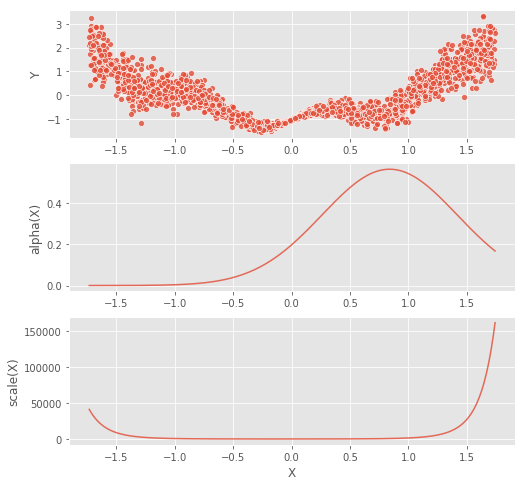

In [36]:
# plot result
alpha_y_reg = alpha2(x).data.numpy()
scale_y_reg = scale2(x).data.numpy()
fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.scatterplot(X, Yobs, alpha=0.8, ax=ax[0])
sns.lineplot(X, alpha_y_reg, alpha=0.8, ax=ax[1])
sns.lineplot(X, scale_y_reg, alpha=0.8, ax=ax[2])

ax[0].set_ylabel('Y')
ax[1].set_ylabel('alpha(X)')
ax[2].set_ylabel('scale(X)')
ax[2].set_xlabel('X')

### TODO:
Right now, I'm only training alpha(x) and c(x) for linear regression and polynomial basis expansion.  
1. We need to train regression P(Y | X, alpha(x), c(x)) on top of it
2. Look into different type of parametric model
3. How to prevent optimization from "cheating" (one way is to regularize alpha(x) and c(x))